### Full documentation, including interactive tutorials at https://plantcv.readthedocs.io/en/latest/

In [1]:
# Import PlantCV functions 
from plantcv import plantcv as pcv


In [2]:
# Set the global debug parameter to plot
pcv.params.debug = "plot"


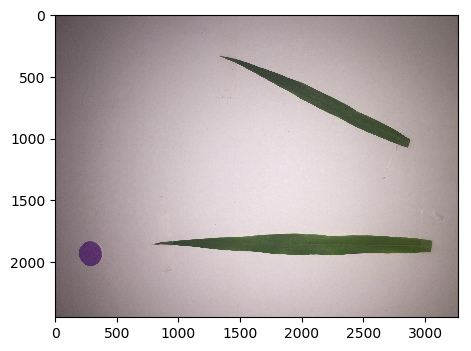

In [3]:
# Read in the image with two largest leaves 
leaf_img, path, filename = pcv.readimage("sataria_leaves.JPG")


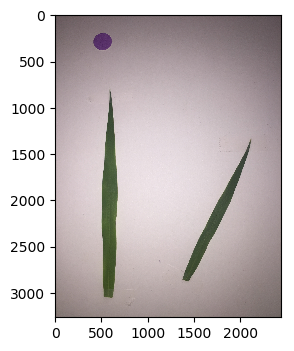

In [4]:
# Rotate the image clockwise 90 degrees to start. 
leaf_img2 = pcv.rotate(img=leaf_img, rotation_deg=-90, crop=False)


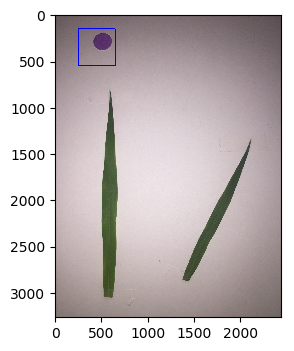

In [5]:
# Increase global line thickness parameter (default=5)
pcv.params.line_thickness = 10

# Draw a region of interest around the size marker 
marker_roi, marker_roi_h = pcv.roi.rectangle(img=leaf_img2, x=250, y=150, h=400, w=400)


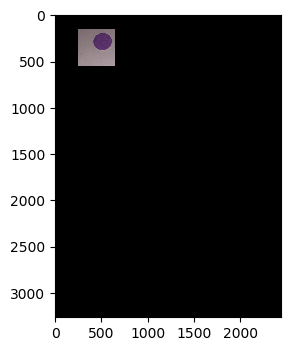

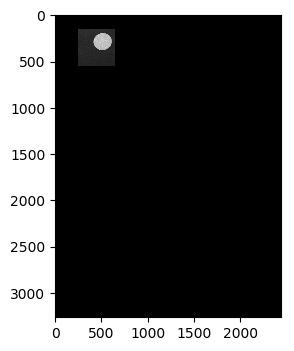

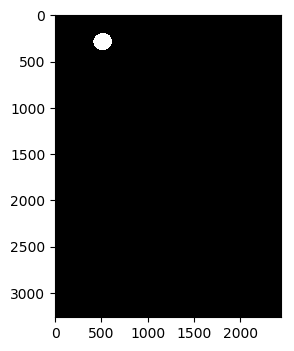

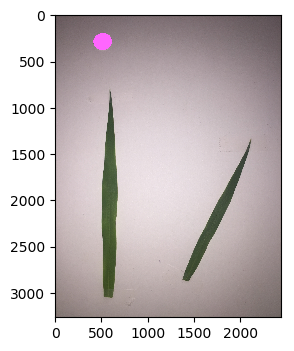

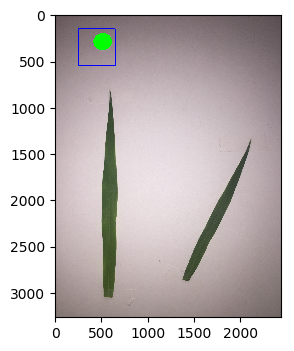

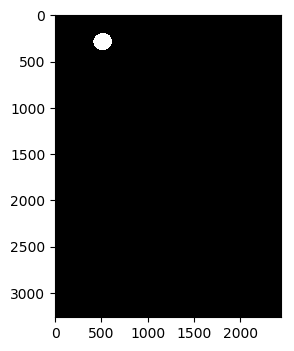

/Users/hschuhl/anaconda3/envs/plantcv/lib/python3.7/site-packages/plantcv-3.3.0+3.ge19d9133-py3.7.egg/plantcv/plantcv/object_composition.py:49: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  group = np.vstack(contours[i] for i in ids)


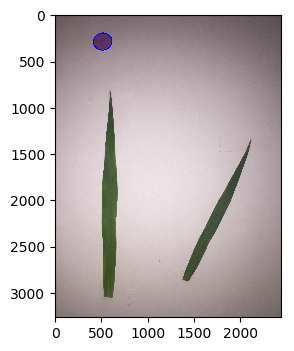

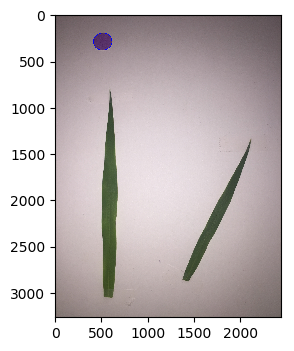

In [6]:
# Find the area of the size marker. The function automatically stores data about size marker area 
# to the Outputs class. 
marker_img = pcv.report_size_marker_area(img=leaf_img2, roi_contour=marker_roi, roi_hierarchy=marker_roi_h, 
                                         marker='detect', objcolor='light', thresh_channel='s', thresh=50)


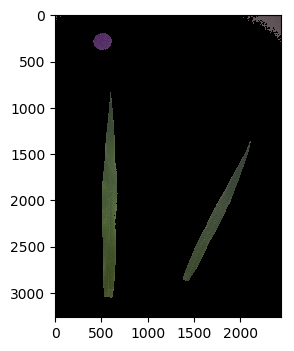

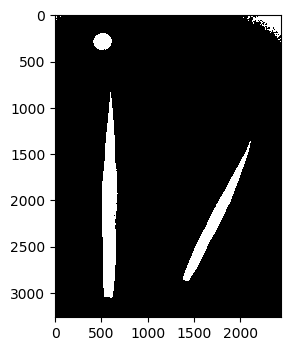

In [7]:
# Threshold out the leaves based on a range of RGB values 
mask, masked_img = pcv.threshold.custom_range(rgb_img=leaf_img2, lower_thresh=[10,10,10], 
                                              upper_thresh=[135,140,100], channel='RGB')


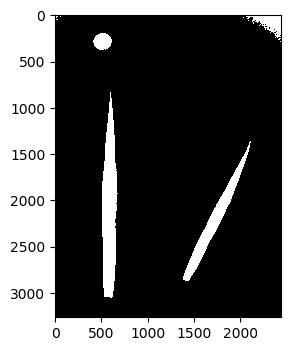

In [8]:
# Close the small dark spots (pepper) in the plant mask
closed_mask = pcv.closing(gray_img=mask)


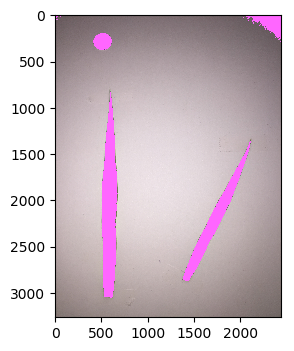

In [9]:
# Find the leaves contour and hierarchy 
id_objects, obj_hierarchy = pcv.find_objects(leaf_img2, closed_mask)


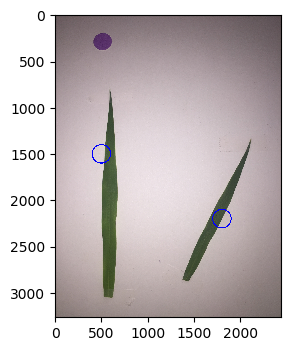

In [10]:
# Use multiple ROIs since we have two leaves that we'd like to measure.
# Regions of interest only need to partially overlab with objects of interest. 
# pcv.roi.multi returns a list of contours, and a list of hierarchies. 
rois, roi_hierarchy = pcv.roi.multi(img=leaf_img2, coord=[(500,1500), (1800,2200)], radius=100)


There are other functions to collect measurements found in the morphology sub-package (Read the Docs
tutorial here https://plantcv.readthedocs.io/en/latest/morphology_tutorial/). Images get labeled with 
data. Users can change text size and thickness with `pcv.params.text_size` and `pcv.params.text_thickness`.
Additionally, using `%matplotlib notebook` will plot images in an interactive window, allowing the user to
zoom in on points of interest. 

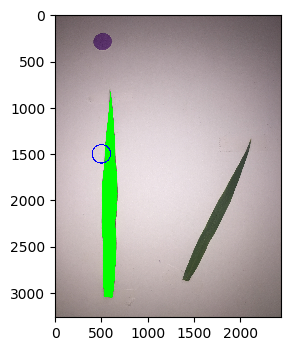

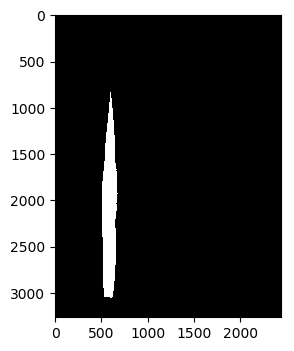

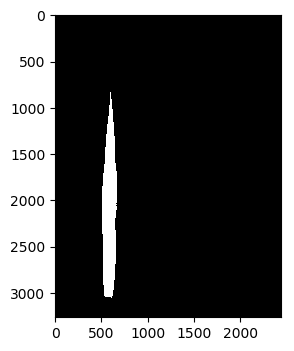

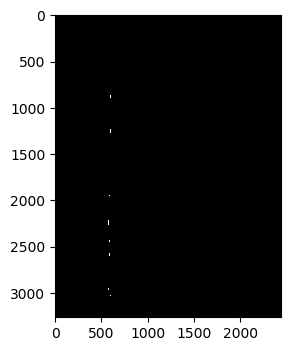

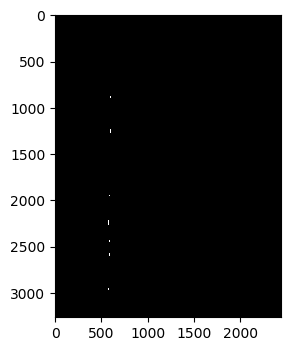

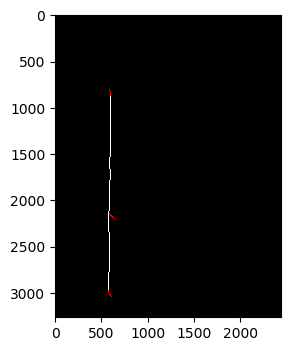

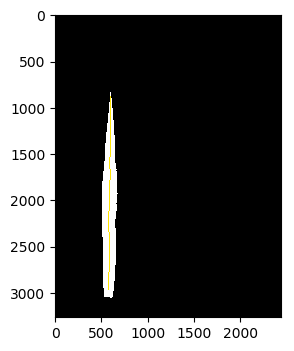

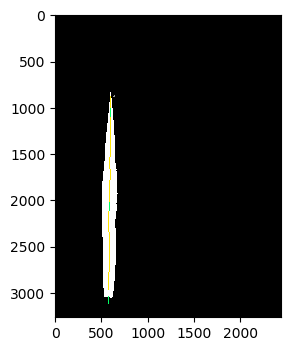

[89.36264340207843]


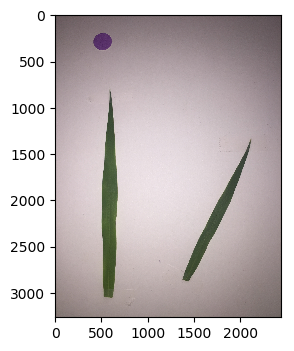

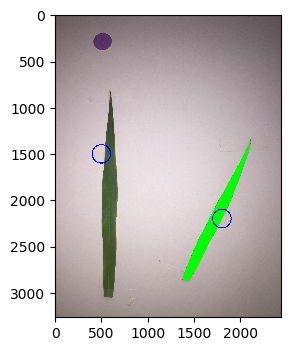

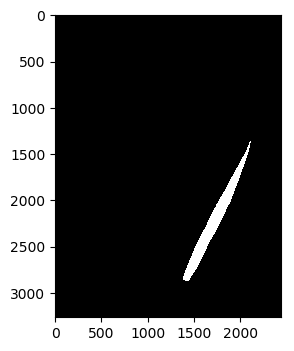

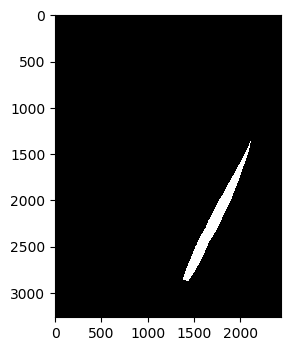

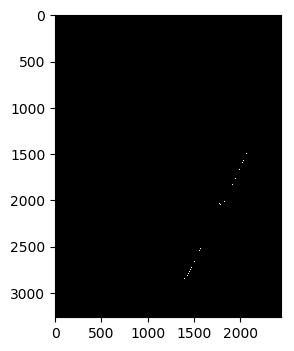

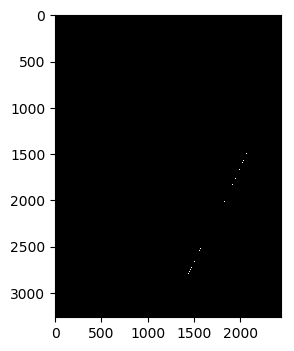

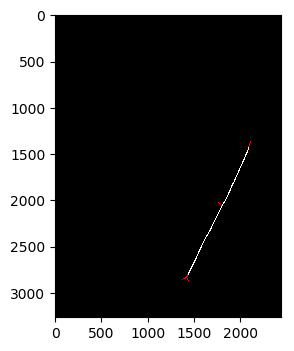

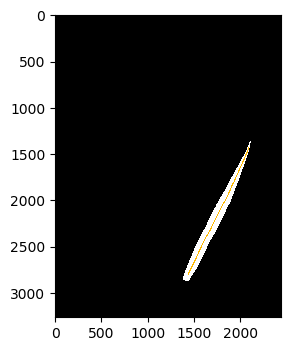

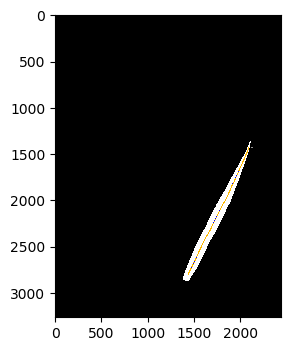

[63.98999327709846]


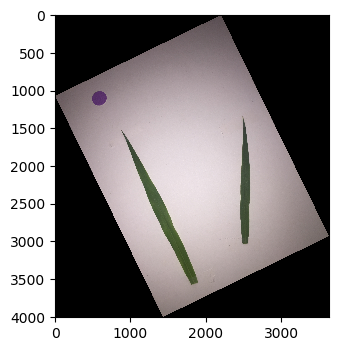

In [11]:
%matplotlib inline

# Loop through and do the same operations to both leaves 
for i in range(0, len(rois)):
    roi = rois[i]
    hierarchy = roi_hierarchy[i]
    
    # Find objects
    contours, hierarchy, mask, area = pcv.roi_objects(img=leaf_img2, roi_type="partial", roi_contour=roi, 
                                                      roi_hierarchy=hierarchy, object_contour=id_objects, 
                                                      obj_hierarchy=obj_hierarchy)
    
    # Erode the plant mask slightly to smooth edges of the leaves 
    eroded = pcv.erode(mask, 4, 1)

    # Skeletonize the leaf mask (make a one-pixel wide representation)
    skeleton_leaf = pcv.morphology.skeletonize(eroded)
    
    # Prune back barbs from the skeleton 
    pruned = pcv.morphology.prune(skel_img=skeleton_leaf, size=75)
    
    # Segment the skeleton into pieces 
    seg_img, edge_objects = pcv.morphology.segment_skeleton(skel_img=pruned, mask=mask)
    
    # Measure the angles of each primary segment 
    labeled_img = pcv.morphology.segment_angle(segmented_img=seg_img, objects=edge_objects)

    # Angle measurements are stored to within observations from the Outputs class
    angle = pcv.outputs.observations['segment_angle']['value']
    print(angle)
    
    # The primary part of the skeleton might be in multiple pieces, so take the average angle 
    average_angle = sum(angle)/len(angle)
    
    # Rotate the image so the leaf is straight up and down 
    rotation_angle = 90 - average_angle
    rotated = pcv.rotate(img=leaf_img2, rotation_deg=int(rotation_angle), crop=False)
    
    # Print out a text file with data collected for each plant in the image 
    pcv.print_results(filename = 'prefix_' + str(i) + '.txt')
    
    # Clear the measurements stored globally into the Ouptuts class
    pcv.outputs.clear()
